__Visualized Transformer Attention with DINO__

Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import timm
import dino
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import cv2
import time
import urllib.request
import keyboard

device = torch.device("cpu")

c:\Users\bjohnson\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Desired resolution and haptic display parameters

In [171]:
display_width = 10
display_height = 6

depth_width = 10*10
depth_height = 10*6

pre_attention_width = 10*10*16
pre_attention_height = 10*6*16

Load ViT Model

In [172]:
#model = timm.create_model('vit_small_patch16_224_dino',pretrained=True)
model = torch.hub.load('facebookresearch/dino:main','dino_vits16')


# Load MiDaS model onto CPU
device = torch.device('cpu')
midas = torch.hub.load("intel-isl/MiDaS","MiDaS_small")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.small_transform

Using cache found in C:\Users\bjohnson/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\bjohnson/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\bjohnson/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\bjohnson/.cache\torch\hub\intel-isl_MiDaS_master


In [173]:
# Setup frame capture
cap = cv2.VideoCapture('video3.mp4') #use video
# cap = cv2.VideoCapture(0) #stream from webcam
previous_frame = None
# Load frame
for n in range(0,10):
    ret= cap.grab()
# if ret is False:
#     break
ret, img = cap.retrieve()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Compute depth

(60, 100)


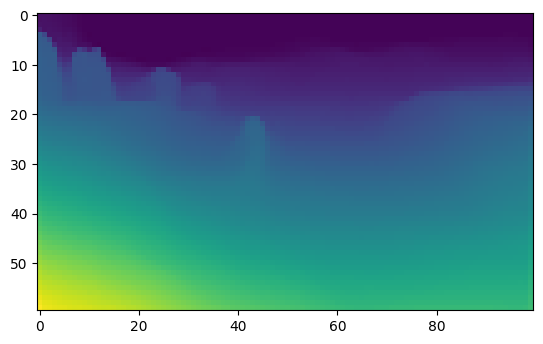

In [174]:
# Compute depth
input_batch = transform(img).to(device)
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=(depth_height, depth_width),
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy()
depth = cv2.normalize(output, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype = cv2.CV_64F)
#depth = (depth).astype(np.uint8)

figure = plt.figure()
plt.imshow(depth)
print(depth.shape)

Pre-process image for attention

In [175]:
attentions_list = []
image = Image.fromarray(img)
Tx = transforms.Resize((pre_attention_height, pre_attention_width))(image)
Tx2 = transforms.ToTensor()(Tx).unsqueeze_(0) # converts to 3-dimension tensor (R, G, B)
Tx3 = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(Tx2)
Tx3.requires_grad = True
print(Tx3.shape)

torch.Size([1, 3, 960, 1600])


Get self attention

In [176]:
model.eval()
model.to(device)
# start_time = time.time()
attentions = model.get_last_selfattention(Tx3)
# print("--- %s seconds ---" % (time.time() - start_time))

nh = attentions.shape[1]
print(attentions.shape)
attentions = attentions[0, :, 3, 1:].reshape(nh,-1)
print(attentions.shape)
patch_size = 16
w_featmap = Tx3.shape[-2] // patch_size
h_featmap = Tx3.shape[-1] // patch_size
print(w_featmap)
print(Tx3.shape[-1])
print(h_featmap)

# interpolate
print(attentions.shape)
attentions = attentions.reshape(nh, w_featmap, h_featmap)
print(attentions.shape)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=1, mode="nearest")[0].detach().numpy()
print(attentions.shape)
attentions_mean = np.mean(attentions, axis=0)
attentions_list.append(attentions_mean)

print(attentions_mean.shape)

torch.Size([1, 6, 6001, 6001])
torch.Size([6, 6000])
60
1600
100
torch.Size([6, 6000])
torch.Size([6, 60, 100])
(6, 60, 100)
(60, 100)


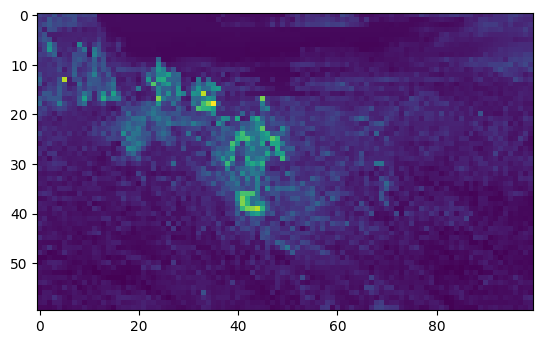

In [177]:
ims = []
figure = plt.figure()
plt.imshow(attentions_mean)
